$$\require{mhchem}$$
# Monod-type denitrification model

In this notebook I use the Monod equations proposed by Störiko et al. 2021 and 2022.

Reactions (Störiko et al 2021):

1. *denitrification 1*: $\ce{7NO3- + C4H6O4 ->[nar] 7NO2- + 4CO2 + 3H2O}$
2. *denitrificantion 2*: $\ce{14NO2- + 14H+ + 3C4H6O4 ->[nir] 7N2 + 12CO2 + 16H2O}$
3. *aerobic respiration*: $\ce{7O2 + 2C4H6O4 -> 7NO2- + 8CO2 + 6H2O}$
---------------
In this model, denitrification rates are described by a Monod term:

$r_{j} = \nu_{max}^i B \frac{C_{j}}{C_{j} + K_{j}} \frac{I_{reac}^i}{I_{reac}^i + C_{O2}} $

for $j \in (nar, nir)$

the aerobic respiration is also described by another monod term:

$r_{\ce{O2}} = \nu_{\ce{O2}}^i B \frac{C_{\ce{O2}}}{C_{\ce{O2}} + K_{\ce{O2}}} \frac{C_{\ce{DOC}}}{C_{\ce{DOC}} + K_{\ce{DOC}}} $  

--------------------
DOC consumption is modelled by adding the stoichiometric corrected rates from the denitrification and aerobic oxidation rates:

$r_{\ce{DOC}}^{j} = \frac{\gamma_{\ce{DOC}}^{j}}{\gamma_{\ce{A}}^{j}}*r_{j}$

for $j \in (nar, nir, \ce{O2})$

and the full rate is defined by the expression:

$r_{DOC} = \sum_j r_{DOC}^j$

DOC release from the sediment contained POC is modelled with the expression:

$r_{rel} = k_{rel}^{DOC}*(C_{DOC}^{sat}- C_{DOC}) $

The final expression for change in $\ce{DOC}$ is then:

$\frac{d[DOC]}{dt} = r_{rel} - r_{DOC} $

---------------------

Bacterial growth is represented by the following reaction:

$\ce{3C4H6O4 + 2NH4+ -> C10H18O5N2 + 2CO2 + 3H2O + 2H+}$

$\ce{NH4+}$ is assumed non limiting. Thus biological growth is modelled with the following expression:

$r_{growth}^{i} = Y_i*r_{DOC}^i$ 

And the specific yield of each consumption reaction is modelled by a logistic function assuming a maximum bacterial growth:

$Y_i = Y_{i,max}*\left(1-\frac{B}{B_{max}}\right)$

Bacterial decay modelled with first order rate:

$r_{dec} = k_{dec}*B$

The final expression for bacterial density change is:

$ \frac{dB}{dt} = \sum_i r_{growth}^{i} - r_{dec}$

#### importing libraries

In [1]:
import os
import numpy as np
import scipy
#import sunode
import matplotlib.pyplot as plt

In [2]:
import sys
sys.executable

'/home/vcantarella/miniconda3/envs/nit-env/bin/python'

In [3]:
# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

# Define the Transport Model

The model we use the is an implicit model in time and discretized in space that solved internally with an ODE solver from scipy (odeint).
To run the model, first we must define the parameters.

## Parameters

We define a dictionary will all the static parameters

In [4]:
parameters = {}

#### transport parameters

In [5]:
parameters['length'] = 0.173 #m
parameters['ne'] = 0.758 #Eff. porosity
parameters['rho_s'] = 2650 #kg/m3 density of grains (maybe lower value?)
parameters['D'] = np.array([1.9e-9/parameters['ne'],1.7e-9/parameters['ne'],0.3e-9/parameters['ne'],0.3e-9/parameters['ne']])
parameters['alpha_l'] = 4.01*1e-4 #m
v = 0.16/(3600*24)
ncells = np.ceil(parameters['length']*v/(1*(np.min(parameters['D'])+parameters['alpha_l']*v)))
ncells = int(ncells)
parameters['ncells'] = ncells

ncells


282

#### NO3 reaction parameters

In [6]:
mu_no3 = 2e-3 #s-1
Y_lac = 1e10
K_no3 = 2 #mmol/L
K_lac = 1.001 #mmol/L
mu_no3_s = 2.75e-6
Y_soc = 9e10 #cell/mmolSOC
K_no3_s = 5 #mmol/L

no3_doc_args = (mu_no3,Y_lac,K_no3,K_lac)
no3_soc_args = (mu_no3_s,Y_soc,K_no3_s)

In [7]:
parameters['no3_doc_args'] = no3_doc_args
parameters['no3_soc_args'] = no3_soc_args

#### NO2 reaction parameters

In [8]:
mu_no2 = 2.5e-3 #s-1
K_no2 = 2 #mmol/L
mu_no2_s = 3e-5
K_no2_s = 2 #mmol/L

no2_doc_args = (mu_no2,K_no2)
no2_soc_args = (mu_no2_s,K_no2_s)

In [9]:
parameters['no2_doc_args'] = no2_doc_args
parameters['no2_soc_args'] = no2_soc_args

#### DOC reaction parameters

In [10]:
k_hyd = 6e-2 #s-1


In [11]:
parameters['k_hyd'] = k_hyd

#### B reaction parameters

In [12]:
k_act = 2e-5 #s-1
C_thresh = 0.48 #mmol/L
st = 0.47
B_args = (k_act,C_thresh,st)

In [13]:
parameters['B_args'] = B_args

### Stress Periods

We define the stress period as the period with constant boundary values it is organized in a list with the time start of each boundary condition and the boundary values of such stress period

In [14]:
Q = np.array([7.883,8.165,8.118,7.847,7.380,7.317]) #ml/hr
q = Q/(np.pi*3.5**2/4)
v_in = q/parameters['ne'] #cm/hr
v_in = v_in*1e-2/3600 #m/s

In [15]:
v_in

array([3.00257490e-06, 3.10998656e-06, 3.09208462e-06, 2.98886278e-06,
       2.81098602e-06, 2.78698980e-06])

In [16]:
tchange = np.array([0,21.6,46.0,69.9,115.4,161.5])*3600
c_in_array = np.array([[2.061,0.013,1e-8,0.12],[2.172,0.005,1e-8,0.444],[3.229,0.001,1e-8,0.667],[3.697,0.014,1e-8,0.553],[4.839,0.004,1e-8,1e-8],[5.011,0.003,1e-8,1e-8]])

In [17]:
v_in[0]

3.0025749020717154e-06

In [18]:
stress_periods = [tchange, c_in_array, v_in]

### Running model

In [19]:
import sys
sys.path.append('../../')

importing the model:

In [20]:
from src.models.strobel_model import column_model_strobel

In [21]:
time_intervals = np.arange(0, 3600*162+600, 600)

In [22]:
sol = column_model_strobel(stress_periods, parameters, time_intervals)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[[-1.96482103e-02  0.00000000e+00 -1.69039404e-32 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.03405194e-25 -1.89471316e-02  2.81732340e-33 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.45197019e-33 -1.05649627e-32 -1.40395804e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.89437065e-03
  -1.90169329e-32  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -1.78712524e-05  2.12874762e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   1.78712524e-05 -2.12874762e-06]]
[[-2.01128311e-02  0.00000000e+00 -5.44040393e-22 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.02518992e-22 -1.94117523e-02  5.38271341e-22 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.11991827e-22 -1.07846874e-21 -1.45042011e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.0000000

### Importing the data

In [23]:
data = np.loadtxt('../../data/external/data_strobel_biostimulation.txt')
time_hrs = data[:,0]
time_sc = time_hrs/3600
no3 = data[:,2]
no2 = data[:,3]
lac = np.zeros(len(data))

#### Plotting and comparing solutions:

In [24]:
plot_time = time_intervals/3600

Text(0, 0.5, '[NO2] [$mmol/L$]')

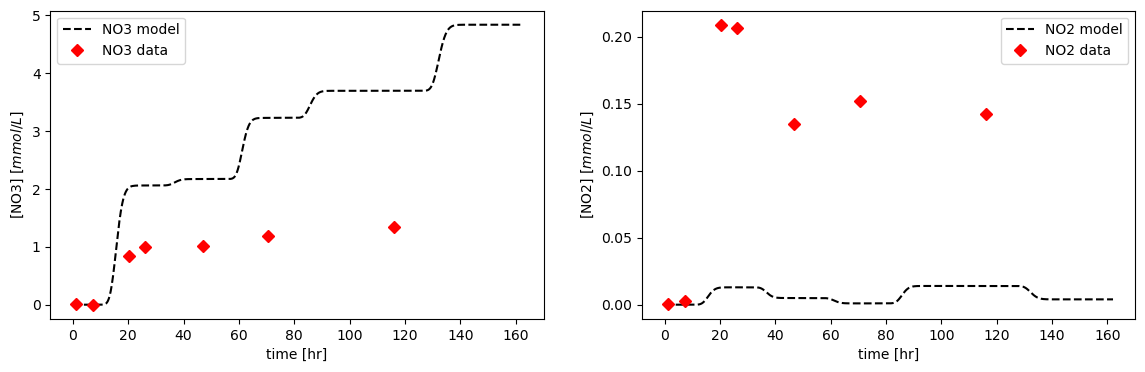

In [25]:
fig = plt.figure(figsize = (14,4))
ax = fig.add_subplot(121)
ax.plot(plot_time,sol[:,0],'--k', label = 'NO3 model')
ax.plot(time_hrs,no3,'Dr', label = 'NO3 data')
#ax.set_xlim([0,6])
ax.legend()
ax.set_xlabel('time [hr]')
ax.set_ylabel(r'[NO3] [$mmol/L$]')
ax2 = fig.add_subplot(122)
ax2.plot(plot_time,sol[:,1],'--k', label = 'NO2 model')
ax2.plot(time_hrs,no2,'Dr', label = 'NO2 data')
#ax.set_xlim([0,6])
ax2.legend()
ax2.set_xlabel('time [hr]')
ax2.set_ylabel(r'[NO2] [$mmol/L$]')

Text(0, 0.5, '[C_x] [$mmol/L$]')

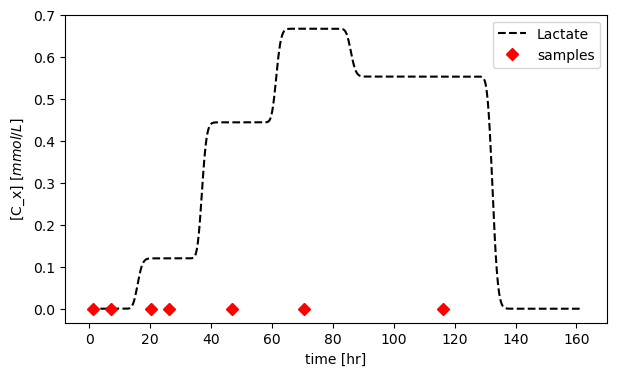

In [26]:
fig = plt.figure(figsize = (7,4))
ax = fig.add_subplot(111)
ax.plot(plot_time,sol[:,3],'--k', label = 'Lactate')
ax.plot(time_hrs,lac,'Dr', label = 'samples')
#ax.plot(plot_time[::40],sol[:,5][::40],'-*k', label = 'inactive')

#ax.plot(plot_time[::50],c_out_ana[::50], 'Dr', label = 'analytical solution')
#ax.plot(plot_time,c_ode[:,-1],'-.k', label = 'remodel')
#ax.set_xlim([0,6])
ax.legend()
ax.set_xlabel('time [hr]')
ax.set_ylabel(r'[C_x] [$mmol/L$]')

Text(0, 0.5, '[B] [$mol/L$]')

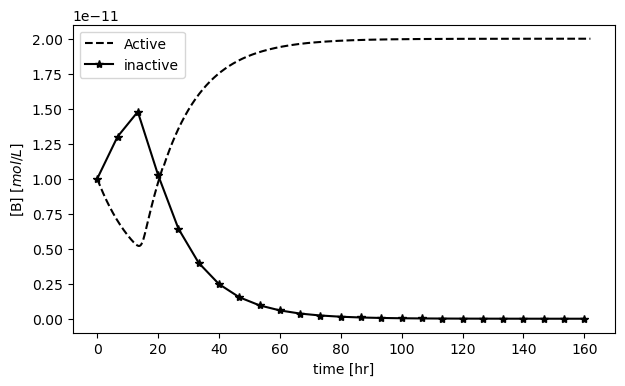

In [27]:
fig = plt.figure(figsize = (7,4))
ax = fig.add_subplot(111)
ax.plot(plot_time,sol[:,4],'--k', label = 'Active')
ax.plot(plot_time[::40],sol[:,5][::40],'-*k', label = 'inactive')

#ax.plot(plot_time[::50],c_out_ana[::50], 'Dr', label = 'analytical solution')
#ax.plot(plot_time,c_ode[:,-1],'-.k', label = 'remodel')
#ax.set_xlim([0,6])
ax.legend()
ax.set_xlabel('time [hr]')
ax.set_ylabel(r'[B] [$mol/L$]')